# 使用回归方法，预测房产价格

这个工程中，将应用回归树、线性回归、xgboost回归等机器学习的方法，对房产的价格进行预测。
具体的步骤简述如下：

1，载入并观察数据；
2，categorical类型特征工程；
3，numerical类特征工程；
4，处理异常值；
5，构造机器学习模型；
6，输入处理后数据，并交叉验证，选择最优模型；
7，按照evaluation规定，对模型的准确度进行评价

## 载入所需要的库文件

In [230]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

%matplotlib inline

## 载入训练集及测试集 

In [2]:
df_train = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')

## 对训练集及数据集进行初步的观察和理解。

In [3]:
# check the columns
print('Training set columns')
df_train.columns

Training set columns


Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## 对数据集的个数进行观察

In [4]:
print("Training set size is %d"%df_train.shape[0])
print("Testing set size is %d"%df_test.shape[0])

Training set size is 1460
Testing set size is 1459


## 观察数据集中，存在异常值的情况

In [5]:
print('Count the na entries in each train set columns')
df_train.isnull().sum()

Count the na entries in each train set columns


Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         0
TotRmsAbvGrd        0
Functional          0
Fireplaces          0
FireplaceQu       690
GarageType         81
GarageYrBlt        81
GarageFinish       81
GarageCars          0
GarageArea          0
GarageQual         81
GarageCond         81
PavedDrive

In [6]:
print('Count the na entries in each test set columns')
df_test.isnull().sum()

Count the na entries in each test set columns


Id                  0
MSSubClass          0
MSZoning            4
LotFrontage       227
LotArea             0
Street              0
Alley            1352
LotShape            0
LandContour         0
Utilities           2
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         1
Exterior2nd         1
MasVnrType         16
MasVnrArea         15
ExterQual           0
ExterCond           0
Foundation          0
                 ... 
HalfBath            0
BedroomAbvGr        0
KitchenAbvGr        0
KitchenQual         1
TotRmsAbvGrd        0
Functional          2
Fireplaces          0
FireplaceQu       730
GarageType         76
GarageYrBlt        78
GarageFinish       78
GarageCars          1
GarageArea          1
GarageQual         78
GarageCond

## 观察一下，训练集与测试集在异常值方面的不同

下述的特征，在训练集及测试集中存在不同的异常情况。在异常处理中，需要进行特殊的处理

In [7]:
train_index = df_train.iloc[:, :-1].isnull().sum()>0
test_index = df_test.isnull().sum()>0
diff = np.logical_xor(train_index, test_index)

diff_index = diff[diff==True].index
print(diff_index)

Index(['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'KitchenQual', 'Functional', 'GarageCars', 'GarageArea',
       'SaleType'],
      dtype='object')


## 首先简要观察一下训练集中的数据

In [8]:
print('Take a quick look at a few samples')
df_train.head(5)

Take a quick look at a few samples


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 分辨categorical与numerical类型特征

In [9]:
quantitative = []
qualitative = []

quantitative = [f for f in df_train.columns if df_train.dtypes[f] != 'object']
quantitative.remove('Id')
quantitative.remove('SalePrice')
qualitative = [f for f in df_train.columns if df_train.dtypes[f] == 'object']

print('numerical features include:')
print(quantitative)
print('categorical features include:')
print(qualitative)

numerical features include:
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
categorical features include:
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQ

### categorical特征

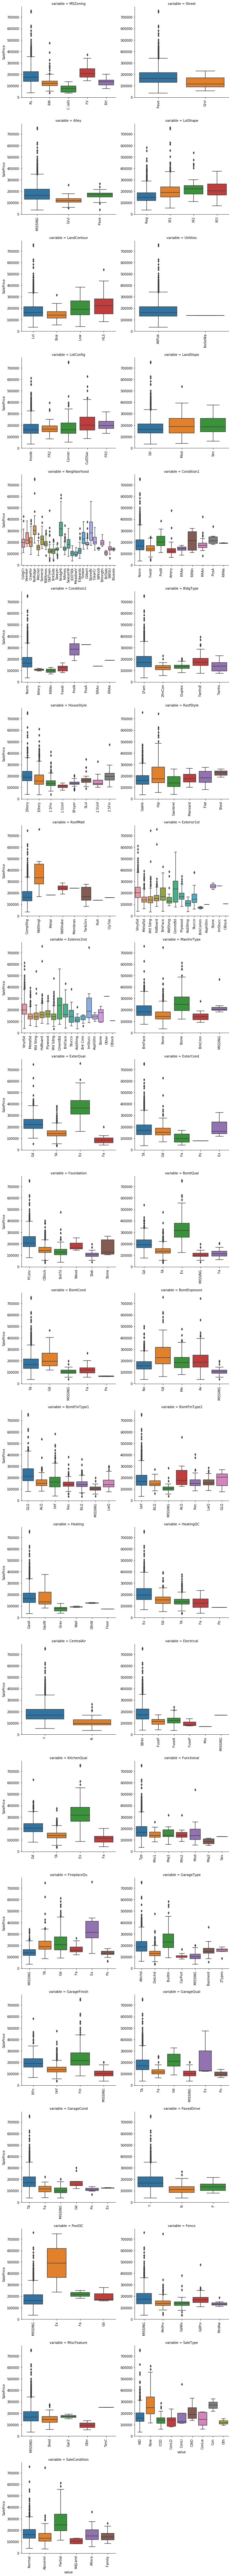

In [10]:
for f in qualitative:
    df_train[f] = df_train[f].astype('category')
    df_test[f] = df_test[f].astype('category')
    if df_train[f].isnull().any():
        df_train[f] = df_train[f].cat.add_categories(['MISSING'])
        df_train[f] = df_train[f].fillna('MISSING')
    if df_test[f].isnull().any():
        df_test[f] = df_test[f].cat.add_categories(['MISSING'])
        df_test[f] = df_test[f].fillna('MISSING')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x = plt.xticks(rotation=90)
f = pd.melt(df_train, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable", col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(boxplot, 'value', 'SalePrice')

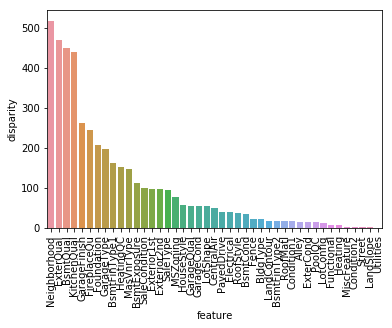

In [11]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = qualitative
    pvals = []
    for c in qualitative:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c]==cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(df_train)
a['disparity'] = np.log(1./a['pval'].values)
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

In [12]:
print("if pval == 0.01, then log(1./pval) = %f"%np.log(1./0.01))
print("if pval == 0.05, then log(pval) = %f"%np.log(1./0.05))

if pval == 0.01, then log(1./pval) = 4.605170
if pval == 0.05, then log(pval) = 2.995732


In [13]:
def encode(frame, feature):
    ordering = pd.DataFrame()
    ordering['val'] = frame[feature].unique()
    ordering.index = ordering.val
    ordering['spmean']= frame[[feature,'SalePrice']].groupby(feature).mean()['SalePrice']
    ordering = ordering.sort_values('spmean')
    ordering['order'] = range(1, ordering.shape[0]+1)
    ordering = ordering.order.to_dict()
    
    for val, ord in ordering.items():
        frame.loc[frame[feature]==val, feature+'_E'] = ord
        
    return ordering

qual_encoded = []
train_ordering = {}
for q in qualitative:
    train_ordering[q] = encode(df_train, q)
    qual_encoded.append(q+'_E')
print(qual_encoded)

['MSZoning_E', 'Street_E', 'Alley_E', 'LotShape_E', 'LandContour_E', 'Utilities_E', 'LotConfig_E', 'LandSlope_E', 'Neighborhood_E', 'Condition1_E', 'Condition2_E', 'BldgType_E', 'HouseStyle_E', 'RoofStyle_E', 'RoofMatl_E', 'Exterior1st_E', 'Exterior2nd_E', 'MasVnrType_E', 'ExterQual_E', 'ExterCond_E', 'Foundation_E', 'BsmtQual_E', 'BsmtCond_E', 'BsmtExposure_E', 'BsmtFinType1_E', 'BsmtFinType2_E', 'Heating_E', 'HeatingQC_E', 'CentralAir_E', 'Electrical_E', 'KitchenQual_E', 'Functional_E', 'FireplaceQu_E', 'GarageType_E', 'GarageFinish_E', 'GarageQual_E', 'GarageCond_E', 'PavedDrive_E', 'PoolQC_E', 'Fence_E', 'MiscFeature_E', 'SaleType_E', 'SaleCondition_E']


In [14]:
for index, di in train_ordering.items():
    for val, ord in di.items():
        df_test.loc[df_test[index]==val, index+'_E'] = ord

## 相关性分析

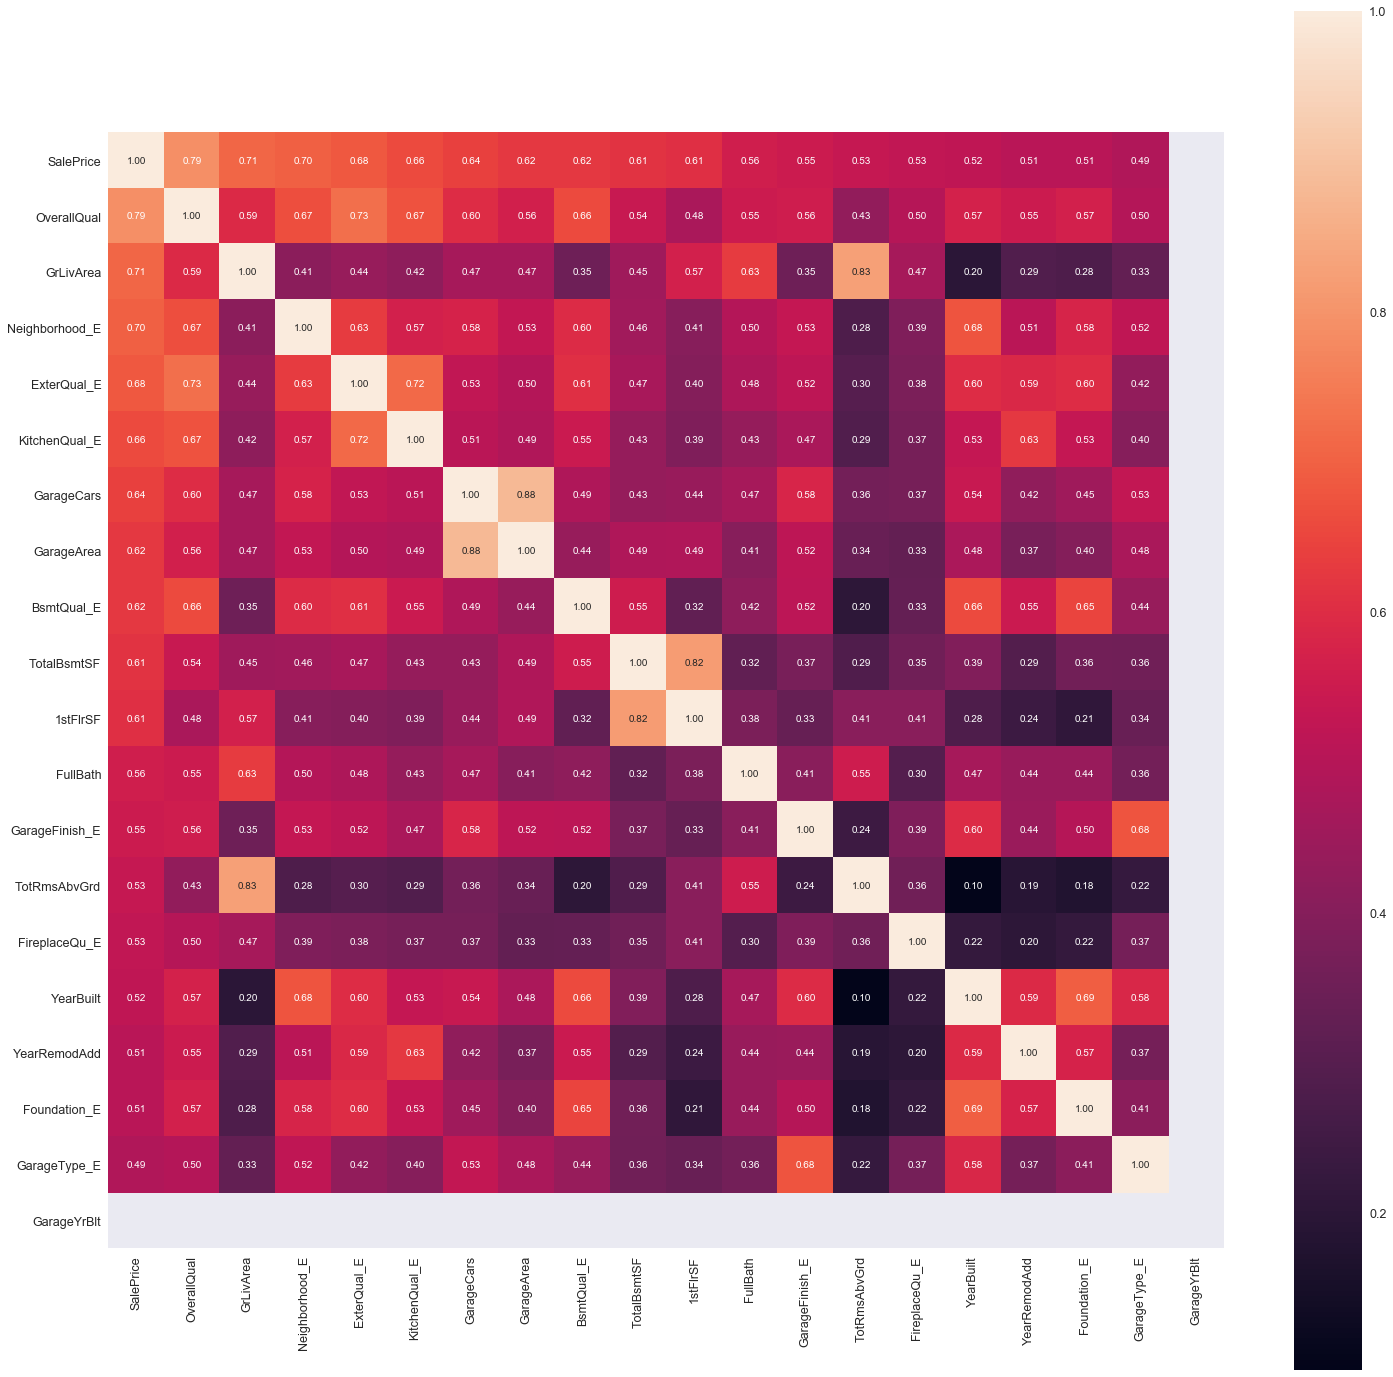

In [15]:
corrmat = df_train.corr()
k = 20
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(25,25))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

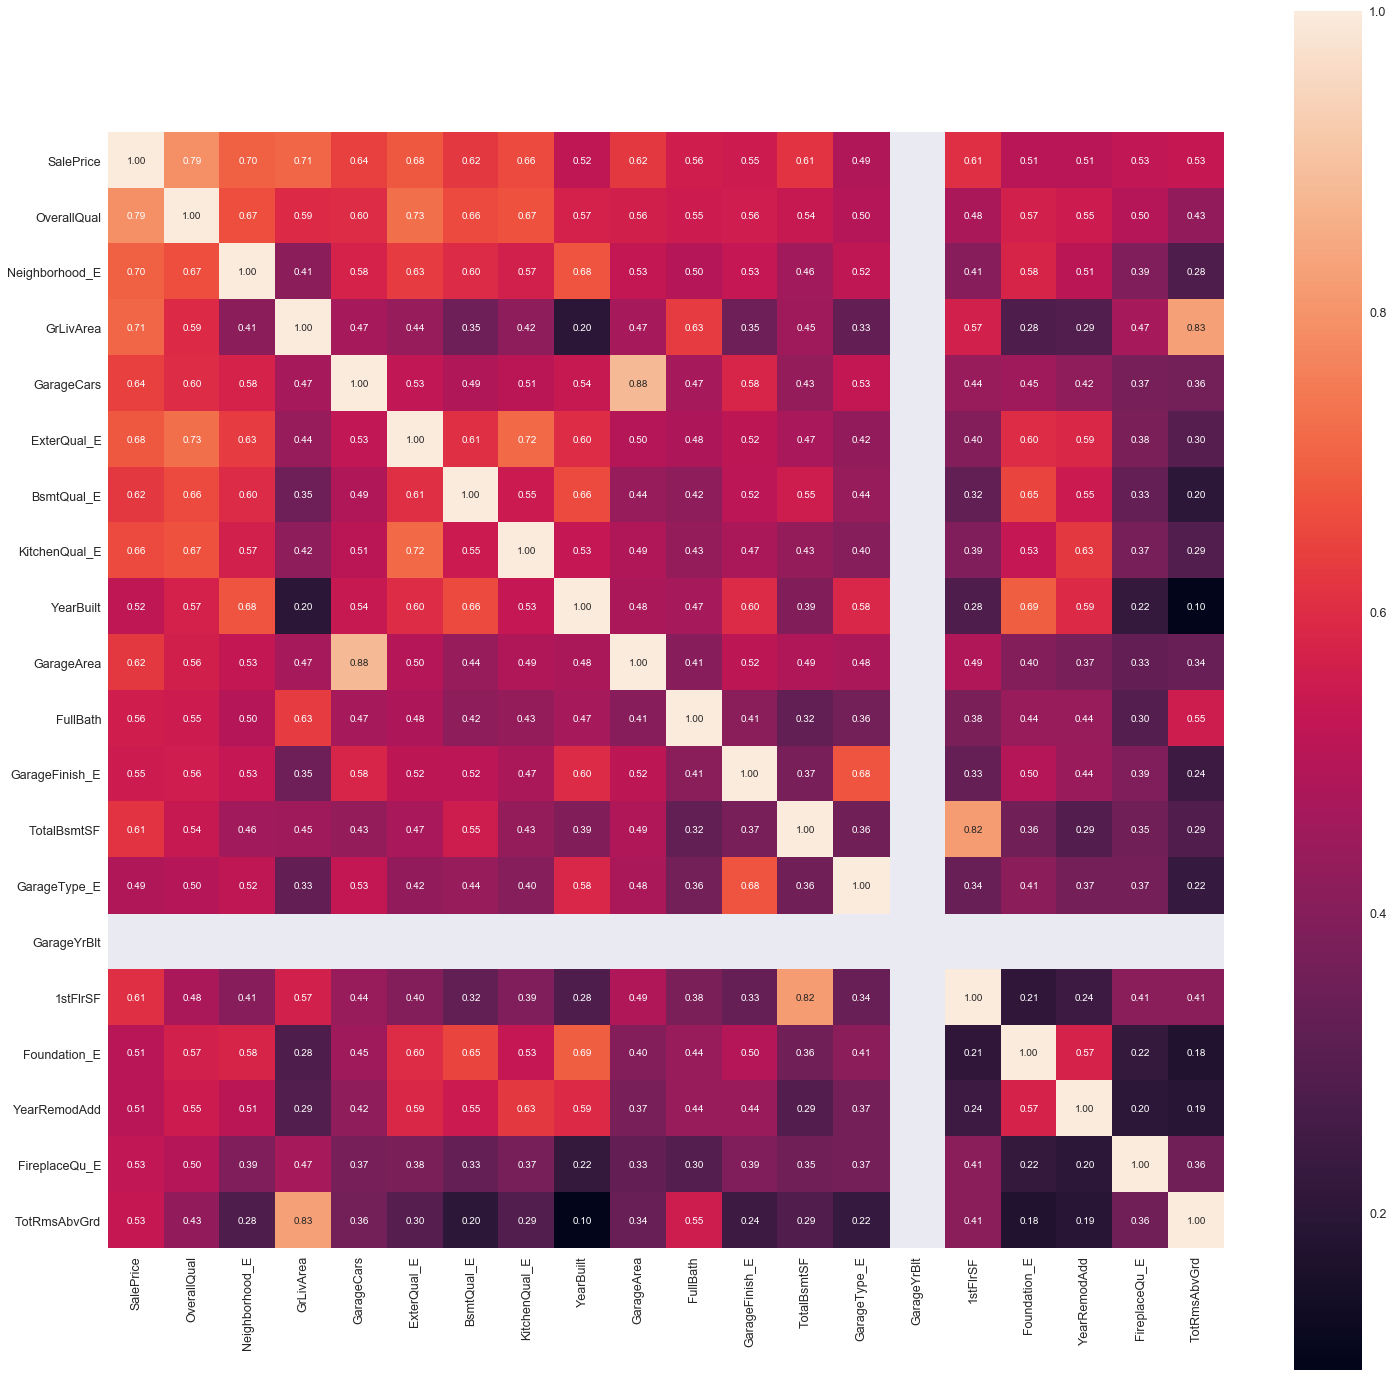

In [16]:
corrmat = df_train.corr(method='spearman')
k = 20
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize=(25,25))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [17]:
k = 11
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
print(cols)

Index(['SalePrice', 'OverallQual', 'Neighborhood_E', 'GrLivArea', 'GarageCars',
       'ExterQual_E', 'BsmtQual_E', 'KitchenQual_E', 'YearBuilt', 'GarageArea',
       'FullBath'],
      dtype='object')


In [59]:
features = [
    'OverallQual', 
    'Neighborhood_E', 
    'GrLivArea', 
    'GarageCars', 
    'BsmtQual_E', 
    'KitchenQual_E',
    'YearBuilt',
    'FullBath',
    'TotalBsmtSF'
]

## 异常值处理

In [19]:
print('Count the na entries in each train set columns')
df_train[features].isnull().sum()

Count the na entries in each train set columns


OverallQual       0
Neighborhood_E    0
GrLivArea         0
GarageCars        0
BsmtQual_E        0
KitchenQual_E     0
FullBath          0
TotalBsmtSF       0
dtype: int64

In [20]:
print('Count the na entries in each test set columns')
df_test[features].isnull().sum()

Count the na entries in each test set columns


OverallQual       0
Neighborhood_E    0
GrLivArea         0
GarageCars        1
BsmtQual_E        0
KitchenQual_E     1
FullBath          0
TotalBsmtSF       1
dtype: int64

In [21]:
GC_abnorm = df_test[df_test['GarageCars'].isnull()]
KQ_abnorm = df_test[df_test['KitchenQual_E'].isnull()]
TB_abnorm = df_test[df_test['TotalBsmtSF'].isnull()]

In [22]:
print(TB_abnorm['1stFlrSF'])

660    896
Name: 1stFlrSF, dtype: int64


In [23]:
TB_dis = df_test[(df_test['1stFlrSF']<950) & (df_test['1stFlrSF']>850)]

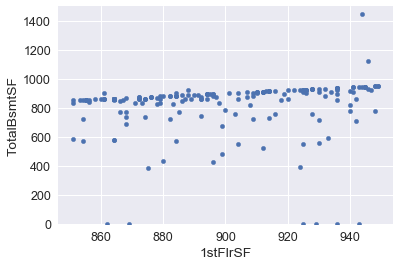

In [24]:
var = '1stFlrSF'
data = pd.concat([TB_dis['1stFlrSF'], TB_dis['TotalBsmtSF']], axis=1)
data.plot.scatter(x=var, y='TotalBsmtSF', ylim=(0, 1500))

In [25]:
df_test.loc[df_test['TotalBsmtSF'].isnull(), 'TotalBsmtSF'] = (
    TB_dis['TotalBsmtSF'].mean())

In [26]:
df_test.loc[df_test['GarageCars'].isnull(), 'GarageCars'] = 0

In [27]:
KQ_dis = df_test[df_test['ExterQual_E']==2]
KQ_dis.KitchenQual_E.describe()

count    891.000000
mean       2.162738
std        0.468566
min        1.000000
25%        2.000000
50%        2.000000
75%        2.000000
max        4.000000
Name: KitchenQual_E, dtype: float64

In [28]:
df_test.loc[KQ_abnorm.index, 'KitchenQual_E'] = 2

## Numerical特征工程

### 正态性

In [29]:
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

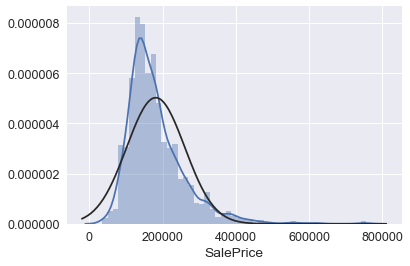

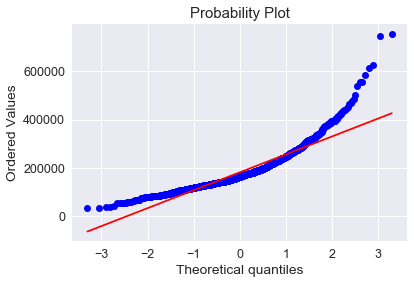

In [30]:
sns.distplot(df_train['SalePrice'], fit=norm)
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

In [31]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])

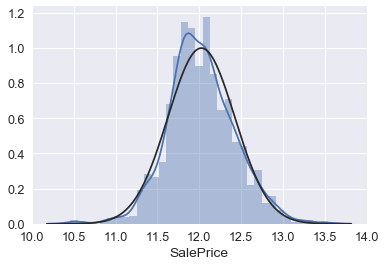

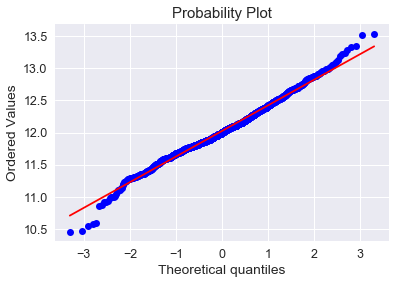

In [32]:
sns.distplot(df_train['SalePrice'], fit=norm)
fig = plt.figure()
res = stats.probplot(df_train['SalePrice'], plot=plt)

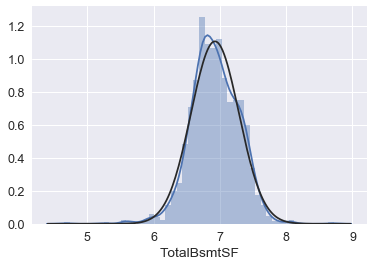

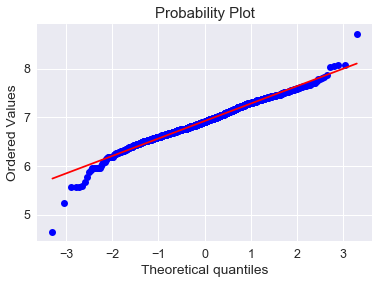

In [33]:
df_train['HasBsmt'] = pd.Series(len(df_train['TotalBsmtSF']), index=df_train.index)
df_train['HasBsmt'] = 0
df_train.loc[df_train['TotalBsmtSF']>0,'HasBsmt'] = 1

df_train.loc[df_train['HasBsmt'] == 1, 'TotalBsmtSF'] = np.log(df_train.loc[df_train['HasBsmt'] == 1, 'TotalBsmtSF'])

sns.distplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm)
fig = plt.figure()
res = stats.probplot(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

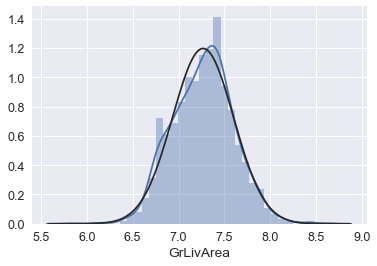

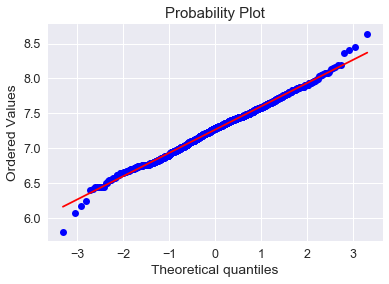

In [34]:
df_train['GrLivArea'] = np.log(df_train['GrLivArea'])

sns.distplot(df_train['GrLivArea'], fit=norm)
fig = plt.figure()
res = stats.probplot(df_train['GrLivArea'], plot=plt)

In [35]:
df_test['GrLivArea'] = np.log(df_test['GrLivArea'])

df_test['HasBsmt'] = pd.Series(len(df_test['TotalBsmtSF']), index=df_test.index)
df_test['HasBsmt'] = 0
df_test.loc[df_test['TotalBsmtSF']>0,'HasBsmt'] = 1

df_test.loc[df_test['HasBsmt'] == 1, 'TotalBsmtSF'] = np.log(df_test.loc[df_test['HasBsmt'] == 1, 'TotalBsmtSF'])

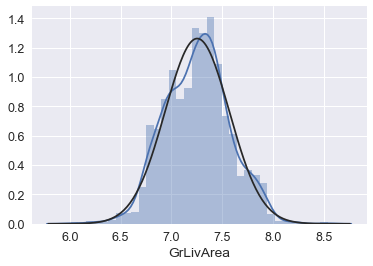

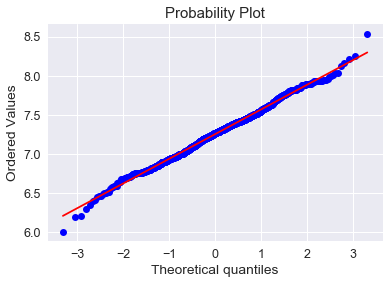

In [36]:
sns.distplot(df_test['GrLivArea'], fit=norm)
fig = plt.figure()
res = stats.probplot(df_test['GrLivArea'], plot=plt)

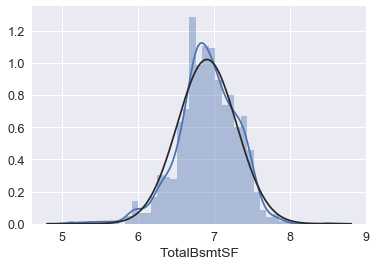

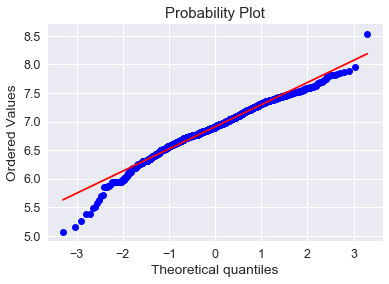

In [37]:
sns.distplot(df_test[df_test['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm)
fig = plt.figure()
res = stats.probplot(df_test[df_test['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

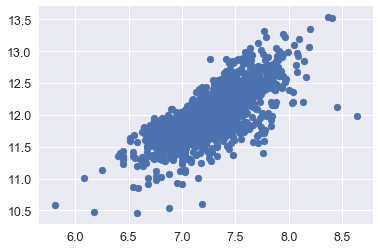

In [38]:
plt.scatter(df_train['GrLivArea'], df_train['SalePrice'])

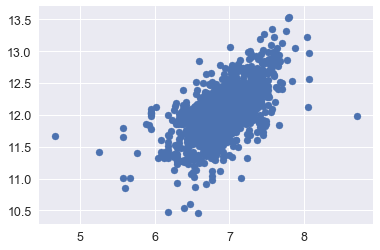

In [39]:
plt.scatter(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'], df_train[df_train['TotalBsmtSF']>0]['SalePrice'])

## 构造输入至模型中的训练集测试集。

In [60]:
X_train = df_train[features]
y_train = df_train['SalePrice']
X_test = df_test[features]

In [61]:
miss_data = pd.DataFrame({'amount': X_train.isnull().sum(), 'ratio':X_train.isnull().sum() / X_train.shape[0]})
print(miss_data)

                amount  ratio
OverallQual          0    0.0
Neighborhood_E       0    0.0
GrLivArea            0    0.0
GarageCars           0    0.0
BsmtQual_E           0    0.0
KitchenQual_E        0    0.0
YearBuilt            0    0.0
FullBath             0    0.0
TotalBsmtSF          0    0.0


In [62]:
miss_data = pd.DataFrame({'amount': X_test.isnull().sum(), 'ratio':X_test.isnull().sum() / X_test.shape[0]})
print(miss_data)

                amount  ratio
OverallQual          0    0.0
Neighborhood_E       0    0.0
GrLivArea            0    0.0
GarageCars           0    0.0
BsmtQual_E           0    0.0
KitchenQual_E        0    0.0
YearBuilt            0    0.0
FullBath             0    0.0
TotalBsmtSF          0    0.0


# 建立机器学习模型，进行训练

In [231]:
import xgboost as xgb
from sklearn.ensemble import (RandomForestRegressor, 
                              AdaBoostRegressor, 
                              GradientBoostingRegressor, 
                              ExtraTreesRegressor)
from sklearn.svm import SVR
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error

## 第一步，是建立具有统一接口的类

In [121]:
class SklearnRegressor(object):
    def __init__(self, clf,params=None):
        self.clf = clf(**params)
        
    def train(self, X, y):
        self.clf.fit(X, y)
    
    def predict(self, X):
        return self.clf.predict(X)
    
    def fit(self, X, y ):
        return self.clf.fit(X, y)

In [71]:
ntrain = X_train.shape[0]
ntest = X_test.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(ntrain, n_folds=NFOLDS, random_state=SEED)

## 应用OOF方法，训练第一层模型

In [72]:
def oof_train(clf, X, y, X_test):
# def oof_train(clf, X, y):
    train_out = np.zeros((ntrain,))
    test_out = np.zeros((ntest,))
    oof_out = np.zeros((NFOLDS, ntest))
    
    for i, (train_index, val_index) in enumerate(kf):
        x_tr = X[train_index]
        y_tr = y[train_index]
        x_val = X[val_index]
        
        clf.train(x_tr, y_tr)
        
        train_out[val_index] = clf.predict(x_val)
        oof_out[i, :] = clf.predict(X_test)
    
    test_out = oof_out.mean(axis=0)
    return train_out.reshape(-1, 1), test_out.reshape(-1, 1)

## 初步设定模型参数

In [135]:
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0,
    'random_state' : SEED
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0,
    'random_state' : SEED
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75,
    'random_state' : SEED
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0,
    'random_state' : SEED
}

# Support Vector Regressor parameters 
svr_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

按照预设参数，初始化模型

In [136]:
rf = SklearnRegressor(clf=RandomForestRegressor, params=rf_params)
et = SklearnRegressor(clf=ExtraTreesRegressor, params=et_params)
ada = SklearnRegressor(clf=AdaBoostRegressor, params=ada_params)
gb = SklearnRegressor(clf=GradientBoostingRegressor, params=gb_params)
svr = SklearnRegressor(clf=SVR, params=svr_params)

在这里，插入对于cross validation的使用。
使用参数较少的svr进行试验。

In [157]:
X = X_train.values
y = y_train.values
X_t = X_test.values

print(X.shape)
print(X_t.shape)

(1460, 9)
(1459, 9)


In [163]:
def cv_train(clf, X, y):
    train_out = np.zeros((ntrain,))
    
    for i, (train_index, val_index) in enumerate(kf):
        x_tr = X[train_index]
        y_tr = y[train_index]
        x_val = X[val_index]
        
        clf.train(x_tr, y_tr)
        train_out[val_index] = clf.predict(x_val)
   
    error = np.sqrt(mean_squared_error(y_true=y, y_pred=train_out))
    return error

In [174]:
c_list = [0.005, 0.01, 0.015, 0.02]
lowest_err = np.inf
for c in c_list:
    params = {
        'kernel': 'linear',
        'C': c
    }
    svr = SklearnRegressor(clf=SVR, params=params)
    err = cv_train(svr, X, y)
    
    if err < lowest_err:
        best_svr = svr
        lowest_err = err
        lowest_c = c

print(lowest_err)
print(lowest_c)

0.160845906694
0.015


In [186]:
# Random Forest parameters
# rf_params = {
#     'n_jobs': -1,
#     'n_estimators': 500,
#      'warm_start': True, 
#      #'max_features': 0.2,
#     'max_depth': 6,
#     'min_samples_leaf': 2,
#     'max_features' : 'sqrt',
#     'verbose': 0,
#     'random_state' : SEED
# }

estimators_list = [10, 50, 100, 150,200]
lowest_err = np.inf
for est in estimators_list:
    # Random Forest parameters
    params = {
        'n_jobs': -1,
        'n_estimators': est,
        'warm_start': True, 
        #'max_features': 0.2,
        'max_depth': 6,
        'min_samples_leaf': 2,
        'max_features' : 'sqrt',
        'verbose': 0,
        'random_state' : SEED
}
    rf = SklearnRegressor(clf=RandomForestRegressor, params=params)
    err = cv_train(rf, X, y)
    
    if err < lowest_err:
        best_rf = rf
        lowest_err = err
        lowest_est = est

print(lowest_err)
print(lowest_est)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:305: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:305: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:305: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:305: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.p

0.130927897353
150


In [196]:
# Extra Trees Parameters
# et_params = {
#     'n_jobs': -1,
#     'n_estimators':500,
#     #'max_features': 0.5,
#     'max_depth': 8,
#     'min_samples_leaf': 2,
#     'verbose': 0,
#     'random_state' : SEED
# }

estimators_list = [170,200,250]
lowest_err = np.inf
for est in estimators_list:
    # Random Forest parameters
# Extra Trees Parameters
    params = {
    'n_jobs': -1,
    'n_estimators':est,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0,
    'random_state' : SEED
}
    et = SklearnRegressor(clf=ExtraTreesRegressor, params=params)
    err = cv_train(et, X, y)
    
    if err < lowest_err:
        best_et = et
        lowest_err = err
        lowest_est = est

print(lowest_err)
print(lowest_est)

0.152540259171
200


In [208]:
# AdaBoost parameters
# ada_params = {
#     'n_estimators': 500,
#     'learning_rate' : 0.75,
#     'random_state' : SEED
# }

lr_list = [0.08, 0.1, 0.15]
est_list = [80, 100, 150, 200]
lowest_err = np.inf
for lr in lr_list:
    for est in est_list:
        params = {
         'n_estimators': est,
         'learning_rate' : lr,
         'random_state' : SEED
        }
        
        ada = SklearnRegressor(clf=AdaBoostRegressor, params=params)
        err = cv_train(ada, X, y)
        
        if err < lowest_err:
            best_ada = ada
            lowest_err = err
            lowest_est = est
            lowest_lr = lr

print(lowest_err)
print(lowest_est)
print(lowest_lr)

0.17789568081
100
0.1


In [216]:
est_list = [10,30, 50,70]
lowest_err = np.inf
for est in est_list:
    params = {
    'n_estimators':est,
    #'max_features': 0.5,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0,
    'random_state' : SEED
}
    gb = SklearnRegressor(clf=GradientBoostingRegressor, params=params)
    err = cv_train(gb, X, y)
    
    if err < lowest_err:
        best_gb = gb
        lowest_err = err
        lowest_est = est

print(lowest_err)
print(lowest_est)

0.148941085761
70


## 将输入数据转化为ndarray类型

In [217]:
et_oof_train, et_oof_test = oof_train(best_et, X, y, X_t)
rf_oof_train, rf_oof_test = oof_train(best_rf, X, y, X_t)
ada_oof_train, ada_oof_test = oof_train(best_ada, X, y, X_t)
gb_oof_train, gb_oof_test = oof_train(best_gb, X, y, X_t)
svr_oof_train, svr_oof_test = oof_train(best_svr, X, y, X_t)

print('Training is completed!')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:305: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Training is completed!


In [218]:
print("RMSE of et regressor %f"
       %np.sqrt(mean_squared_error(y_true=y, y_pred=et_oof_train)))
print("RMSE of rf regressor %f"
       %np.sqrt(mean_squared_error(y_true=y, y_pred=rf_oof_train)))
print("RMSE of ada regressor %f"
       %np.sqrt(mean_squared_error(y_true=y, y_pred=ada_oof_train)))
print("RMSE of gb regressor %f"
       %np.sqrt(mean_squared_error(y_true=y, y_pred=gb_oof_train)))
print("RMSE of svr regressor %f"
       %np.sqrt(mean_squared_error(y_true=y, y_pred=svr_oof_train)))

RMSE of et regressor 0.152540
RMSE of rf regressor 0.130928
RMSE of ada regressor 0.177896
RMSE of gb regressor 0.148941
RMSE of svr regressor 0.160846


In [252]:
xgb_input = pd.DataFrame({'rf':rf_oof_train.ravel(),
                          'et':et_oof_train.ravel(),
                          'ada':ada_oof_train.ravel(),
                          'gb':gb_oof_train.ravel(),
                          'svr':svr_oof_train.ravel()})

xgb_test = pd.DataFrame({'rf':rf_oof_test.ravel(),
                          'et':et_oof_test.ravel(),
                          'ada':ada_oof_test.ravel(),
                          'gb':gb_oof_test.ravel(),
                          'svr':svr_oof_test.ravel()})

xgb_input.head(5)

,ada,et,gb,rf,svr
0,12.243508,12.220385,12.181720,12.210514,12.282824
1,11.899669,12.058469,12.012704,12.029975,12.102360
2,12.243508,12.248507,12.215490,12.222121,12.297925
3,12.243497,12.243461,12.156446,12.192894,12.305034
4,12.585023,12.606791,12.556842,12.591788,12.630826


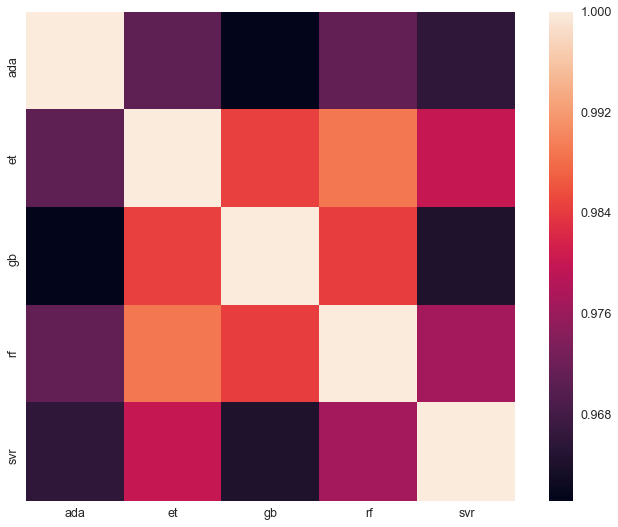

In [220]:
corrmatrix = xgb_input.corr()
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmatrix, square=True)

In [255]:
xgb_X = xgb_input.values
xgb_y = y_train.ravel()

xgb_test_X = xgb_test.values

In [254]:
xgbm = xgb.XGBRegressor(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.5,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'reg:linear',
 nthread= -1,
 scale_pos_weight=1)

xgb_train_out = np.zeros((ntrain,))
xgb_test_out = np.zeros((ntest,))

for i, (train_index,val_index) in enumerate(kf):
    Xf = xgb_X[train_index]
    yf = xgb_y[train_index]
    xgbm.fit(X=Xf, y=yf)
    xgb_train_out[val_index] = xgbm.predict(xgb_X[val_index])
    
xgb_test_out = xgbm.predict(xgb_test_X)

In [256]:
err_lowest = np.inf
estm_list = [2000,3000,3500,4000]
lr_list = [0.01, 0.02, 0.05, 0.075]
for lr in lr_list:
    for est in estm_list:
        params = {
            'learning_rate':lr,
            'n_estimators':est,
            'max_depth':4,
            'min_child_weight':2,
            #gamma=1,
            'gamma':0.5,                        
            'subsample':0.8,
            'colsample_bytree':0.8,
            'objective': 'reg:linear',
            'nthread':-1,
            'scale_pos_weight':1
            }
    
        xgbm = SklearnRegressor(clf=xgb.XGBRegressor, params=params)
        err = cv_train(xgbm, xgb_X, xgb_y)
    
        if err < err_lowest:
            best_xgbm = xgbm
            err_lowest = err
            est_lowest = est
            lr_lowest = lr

print(err_lowest)
print(est_lowest)
print(lr_lowest)

0.134654952426
3500
0.05


In [257]:
xgb_train_out = best_xgbm.predict(xgb_X)
xgb_test_out = best_xgbm.predict(xgb_test_X)

In [259]:
print("RMSE of xgb regressor %f"
       %np.sqrt(mean_squared_error(y_true=xgb_y, y_pred=xgb_train_out)))

RMSE of xgb regressor 0.125297


In [249]:
result = pd.DataFrame()
result['Id'] = df_test['Id']
result['SalePrice'] = np.exp(xgb_test_out)

In [250]:
result.to_csv('result.csv',index=False)

# 总结
可以看出，第二级的回归器在第一级的基础上有一定的提升，但提升有限。 这说明： 1，ensemble的思路具有可行性，因为确实得到了提升； 2，第一级回归器及第二级回归器在当前并没有使用交叉验证调参的方法，这是下一步需要引入的内容； 3，四个初级回归器之间相关性较高，探索降低相关性或其他方法； 4，引入更加强大的回归器用于第一二甚至三级回归器。